In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 31/05/2021

    Code description :
    __________________
Generates a random interferometric matrix F with properties :
        - for all i \in [Q], F_ii = cste => tr (F)=Q F_ii
        - F_ij = F*_ji for all i,j \in [Q]
    And reconstruct F from Rank-One Projections (ROPs) :
        - y = a*Fa 
    Where 'y' is a scalar value for each ROP and 'a' is one projection vector.
    Here, the 'a's are randomly generated.
"""
import matplotlib.pyplot as plt
import numpy as np
import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(), 3),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from graphics import set_plot_params, subplot_axs, labels
from shepp_logan import phantom
set_plot_params() # Set the plot params

Creation of $\mathcal{F}\left[\overline{f}\right]$ matrix

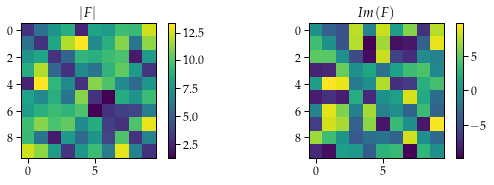

In [2]:
Q = 10

F = np.zeros((Q,Q), dtype=complex)
for i in range(Q):
    F[i,i]=3
    for j in range(i):
        F[i,j] = ((np.random.random(1) + np.random.random(1)*1j)-0.5-0.5j)*20
        F[j,i] = np.conj(F[i,j])

""" Plots """
fig = plt.figure(figsize=(8,2.8))
axs = subplot_axs(fig,1,2)
im1=axs[0].imshow(np.abs(F), cmap='viridis')
im2=axs[1].imshow(np.imag(F), cmap='viridis')
labels(axs[0], '$|F|$')
labels(axs[1], '$Im (F)$')
cb = fig.colorbar(im1, ax=axs[0])
cb2 = fig.colorbar(im2, ax=axs[1])
plt.show()

Creation of random observation $\alpha$ vectors and observations $y$

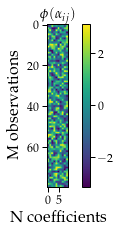

In [3]:
M = 80 # Number of ROP of F
# a_ij = np.exp(2j*np.pi*np.random.random((M,Q)))
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)

"Plot"
plt.figure(figsize=(5,3))
plt.imshow(np.angle(a_ij), cmap='viridis')
plt.colorbar()
plt.title(r'$\phi (\alpha_{ij})$')
plt.ylabel('M observations')
plt.xlabel('N coefficients')
# plt.gca().set_aspect('auto')
plt.show()

y = A(F, a_ij, diagless=False)

Creation of estimator $H$ s.t. $\mathbb{E}\left[ H - \frac{1}{M} \sum_j y_j \mathbb{I}_3 \right] = F$

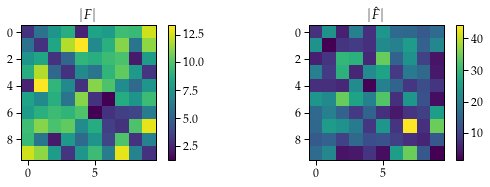

In [4]:
H = A_star2(y, a_ij, diagless=False)
F_hat = H - 1/np.sqrt(M)*np.sum(y)*np.eye(Q) 

""" Plots """
fig = plt.figure(figsize=(8,2.8))
axs = subplot_axs(fig,1,2)
im1=axs[0].imshow(np.abs(F), cmap='viridis')
im2=axs[1].imshow(np.abs(F_hat), cmap='viridis')
labels(axs[0], '$|F|$')
labels(axs[1], '$|\hat{F}|$')
cb = fig.colorbar(im1, ax=axs[0])
cb2 = fig.colorbar(im2, ax=axs[1])
plt.show()

## Check convergence as $M$ increases

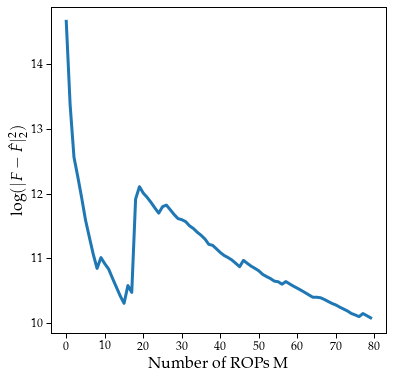

In [5]:
H = np.zeros(F.shape, dtype=complex)
F_hat = np.zeros(F.shape, dtype=complex)
sum_y = 0
diff = np.zeros(M)
y *= np.sqrt(M)

for i in range(M):
    sum_y+=y[i]
    Hnew = y[i]*np.outer(a_ij[i,:],a_ij[i,:].conj())
    H+=Hnew

    F_hat = i/(i+1)*F_hat + 1/(i+1)*(Hnew-(Q-1)/Q*y[i]*np.eye(Q))

    diff[i] = np.sum(np.abs(F_hat-F)**2)
del(a_ij)

plt.figure()
plt.plot(np.log(diff))
plt.xlabel('Number of ROPs M')
plt.ylabel('$\log (|F-\hat{F}|_2^2)$')
plt.show()

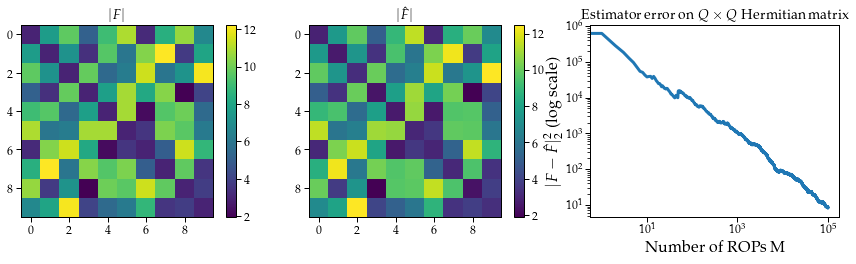

In [6]:
Q = 10
M = 100000

"Random Hermitian matrix creation"
F = np.zeros((Q,Q), dtype=complex)
for i in range(Q):
    F[i,i]=3
    for j in range(i):
        F[i,j] = ((np.random.random(1) + np.random.random(1)*1j)-0.5-0.5j)*20
        F[j,i] = np.conj(F[i,j])

"Measurement vectors"
# a_ij = np.exp(2j*np.pi*np.random.random((M,Q)))
a_ij = (np.random.randn(M,Q)+1j*np.random.randn(M,Q))/np.sqrt(2)

"ROPs"
y = np.zeros(M, dtype=complex)
for i in range(M):
    y[i] = a_ij[i,:].conj()@F@a_ij[i,:]

"Estimation"
H = np.zeros(F.shape, dtype=complex)
F_hat = np.zeros(F.shape, dtype=complex)
sum_y = 0
diff = np.zeros(M)

for i in range(M):
    sum_y+=y[i]
    Hnew = y[i]*np.outer(a_ij[i,:],a_ij[i,:].conj())
    H+=Hnew
    # F_hat = i/(i+1)*F_hat + 1/(i+1)*(Hnew-(Q-1)/Q*y[i]*np.eye(Q))
    F_hat = i/(i+1)*F_hat + 1/(i+1)*(Hnew-y[i]*np.eye(Q))
    diff[i] = np.sum(np.abs(F_hat-F)**2)

""" Plots """
fig = plt.figure(figsize=(12,4))
axs = subplot_axs(fig,1,3)
im1=axs[0].imshow(np.abs(F), cmap='viridis')
im2=axs[1].imshow(np.abs(F_hat), cmap='viridis')
labels(axs[0], '$|F|$')
labels(axs[1], '$|\hat{F}|$')
cb = fig.colorbar(im1, ax=axs[0])
cb2 = fig.colorbar(im2, ax=axs[1])
axs[2].plot(diff)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].set_xlabel('Number of ROPs M')
axs[2].set_ylabel(r'$|F-\hat{F}|_2^2$ (log scale)')
axs[2].set_title(r'Estimator error on $Q \times Q$ Hermitian matrix')
plt.show()